# Tutorial: data integration for spatial multi-omics data

In this tutorial, we demonstrate how to apply FGOT to integrate paired the spatial-ATAC-RNA-seq mouse brain data. The dataset is publicly assessible (https://cells.ucsc.edu/?ds=brain-spatial-omics). After preprocessing, the data used in this experiment can be downloaded from the website (https://drive.google.com/drive/folders/1Hhl5gE8RNwDIuamMNZhOhuKS7aA_YMB-). 

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_4dim, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/P22mousebrain_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_selected_ATAC.txt', sep='\t', index_col=0)

In [4]:
spatial = pd.read_csv(data_path + "Spots.coords.tsv.gz",sep='\t', index_col=0, header=None)
spatial = np.array(spatial)

In [5]:
cell1_cluster = pd.read_csv(data_path + 'P22_putative_clusters.txt', sep='\t')
cell1_cluster = cell1_cluster.reset_index()
cell1_cluster = cell1_cluster.rename(columns={'index':'cell','x': 'cluster'})
cell2_cluster = cell1_cluster.copy()

In [6]:
X1 = RNA_data.T
X2 = ATAC_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(cell1_cluster['cluster'])
basic_labels2 = np.array(cell2_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(RNA_data.columns)
cell_names2 = list(ATAC_data.columns)
gene_names = list(RNA_data.index)
peak_names = list(ATAC_data.index)

Dimensions of input datasets are:  X1 =  (9215, 503)  X2 =  (9215, 5061)
Dimensions of basic_labels are:  basic_labels1 =  (9215,)  basic_labels2 =  (9215,)


## compute feature relationship

In [7]:
promoters = pd.read_csv(data_path+'mm10_TSS.txt', sep = '\t')
promoters = promoters.rename(columns={'start': 'starts','end': 'ends','Gene': 'genes'})
promoters.head()

,chr,starts,ends,genes
1,chr1,3466587,3513553,Gm1992
2,chr1,3205901,3671498,Xkr4
3,chr1,3905739,3986215,Gm37381
4,chr1,4292981,4409187,Rp1_2
5,chr1,3999557,4409241,Rp1


In [8]:
feature_matrix = pre.prior_feature_graph(promoters, gene_names, peak_names, scope=150000)
feature_matrix

27916it [00:00, 324485.14it/s]
27916it [00:01, 24001.48it/s]
100%|██████████| 503/503 [00:00<00:00, 1006.76it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 496 5061 5340


100%|██████████| 5340/5340 [00:00<00:00, 921180.53it/s]


,chr13-97918017-97918907,chr19-24300824-24301679,chr3-14917009-14917924,chr11-107762826-107763736,chr8-84722792-84723543,chr7-28981495-28982409,chr5-44387139-44388051,chr2-25574427-25575305,chr3-105871864-105872689,chr1-90998305-90999218,...,chr12-117427167-117428060,chr18-62921886-62922769,chr8-84793788-84794609,chr18-67165341-67166209,chr15-95295729-95296519,chr13-55329475-55330407,chr18-61505089-61505954,chr8-14906700-14907639,chr11-98909339-98910246,chr8-15018308-15019162
Sulf1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Rims1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Smap1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Ercc5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Wdr75,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cnksr2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Map7d2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Sh3kbp1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Arhgap6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost

wnn to calculate cost

In [9]:
wnn = pd.read_csv(data_path+'P22_wsnn.txt', sep='\t', index_col=0)
wnn

,CTAAGGTCTTGCTGGA,CTAAGGTCACACAGAA,CTAAGGTCACAGCAGA,CTAAGGTCACCTCCAA,CTAAGGTCACGCTCGA,CTAAGGTCACGTATCA,CTAAGGTCACTATGCA,CTAAGGTCAGAGTCAA,CTAAGGTCAGATCGCA,CTAAGGTCAGCAGGAA,...,GAACAGGCCGGATTGC,GAACAGGCCTAAGGTC,GAACAGGCGAACAGGC,GAACAGGCGACAGTGC,GAACAGGCGAGTTAGC,GAACAGGCGATGAATC,GAACAGGCGCCAAGAC,GAACAGGCCGGAAGAA,GAACAGGCGTGACAAG,GAACAGGCGAACCAGA
CTAAGGTCTTGCTGGA,1.000000,0.176471,0.250000,0.081081,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.111111,0.000000,0.000000,0.000000,0.176471
CTAAGGTCACACAGAA,0.176471,1.000000,0.428571,0.176471,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000
CTAAGGTCACAGCAGA,0.250000,0.428571,1.000000,0.176471,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.176471,0.000000,0.000000,0.000000,0.000000,0.081081
CTAAGGTCACCTCCAA,0.081081,0.176471,0.176471,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CTAAGGTCACGCTCGA,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAACAGGCGATGAATC,0.111111,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.212121,1.000000,0.000000,0.000000,0.000000,0.081081
GAACAGGCGCCAAGAC,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.250000,0.290323,0.000000
GAACAGGCCGGAAGAA,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.250000,1.000000,0.904762,0.000000
GAACAGGCGTGACAAG,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.290323,0.904762,1.000000,0.000000


In [10]:
cost = np.array(np.exp(1 - wnn))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

In [ ]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [12]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=gene_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=peak_names)

## solve the feature-guided optimal transport

In [ ]:
P_4dim = fgot_sparse_4dim(X1, X2, feature_matrix, cost, cell1_cluster,cell2_cluster,\
    minibatch=1, batchsize=600, pair = True, device='cuda:6', eps_p = 1e-1, rho=10)

In [15]:
P = fgot_tol(P_4dim)
P.shape

100%|██████████| 5340/5340 [21:28<00:00,  4.14it/s]


(9215, 9215)

Text(0.5, 1.0, 'optimal transport matrix')

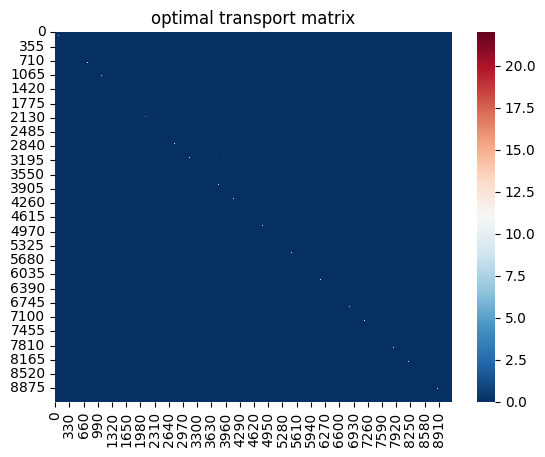

In [16]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [17]:
X1_aligned, X2_aligned = align(X1, X2, P, X2Y=False)

In [18]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['ATAC'] * n2 + ['RNA'] * n1)
adata_aligned.obsm['spatial'] = np.concatenate((spatial,spatial), axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

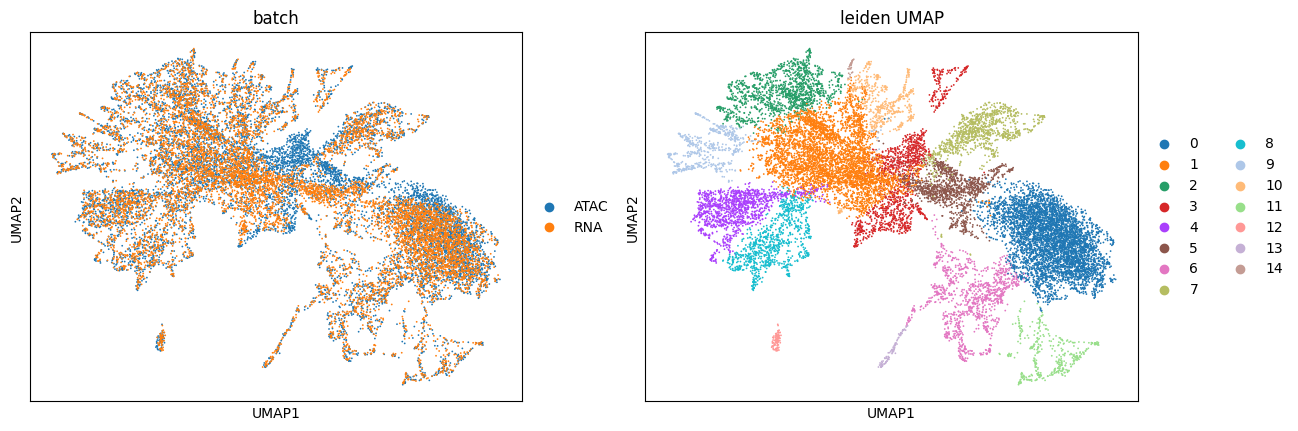

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


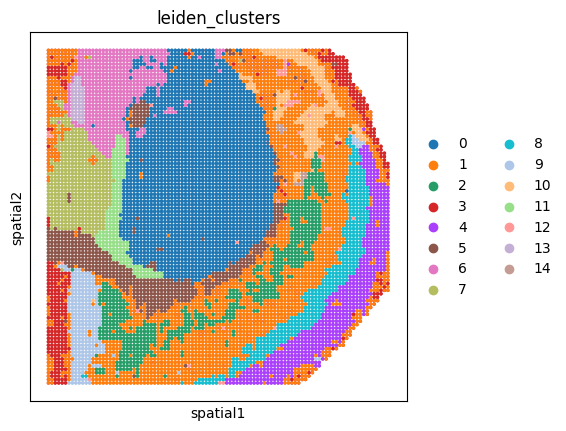

: 

In [19]:
sc.tl.leiden(adata_aligned, key_added='leiden_clusters',resolution=0.3)
sc.pl.umap(adata_aligned, color = ['batch','leiden_clusters'], title=['batch','leiden UMAP'])
sc.pl.spatial(adata_aligned, img_key=None, color="leiden_clusters",spot_size = 1)